In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json

output = {}

In [5]:
cases_deaths = pd.read_csv("https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv").dropna(subset=["date"])
vaccines = pd.read_csv("https://data.chhs.ca.gov/dataset/e283ee5a-cf18-4f20-a92c-ee94a2866ccd/resource/130d7ba2-b6eb-438d-a412-741bde207e1c/download/covid19vaccinesbycounty.csv")

In [6]:
cases_deaths["date"] = pd.to_datetime(cases_deaths["date"])

vaccines["date"] = pd.to_datetime(vaccines["administered_date"])
vaccines = vaccines.drop(["administered_date"], axis=1)

In [4]:
print(cases_deaths.columns)

Index(['date', 'area', 'area_type', 'population', 'cases', 'cumulative_cases',
       'deaths', 'cumulative_deaths', 'total_tests', 'cumulative_total_tests',
       'positive_tests', 'cumulative_positive_tests', 'reported_cases',
       'cumulative_reported_cases', 'reported_deaths',
       'cumulative_reported_deaths', 'reported_tests'],
      dtype='object')


In [7]:
vaccines.county = np.where(vaccines.county == "All CA Counties", "California", vaccines.county)
cases_deaths.area = np.where(cases_deaths.area == "All CA Counties", "California", cases_deaths.area)

In [34]:
vaccines.county.unique()

array(['California', 'All CA and Non-CA Counties', 'Alpine', 'Amador',
       'Butte', 'Calaveras', 'Colusa', 'Del Norte', 'Glenn', 'Humboldt',
       'Imperial', 'Inyo', 'Kings', 'Lake', 'Lassen', 'Madera', 'Marin',
       'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey',
       'Napa', 'Nevada', 'Plumas', 'San Benito', 'Santa Barbara',
       'Shasta', 'Sierra', 'Siskiyou', 'Stanislaus', 'Sutter', 'Tehama',
       'Trinity', 'Tulare', 'Tuolumne', 'Unknown', 'Yuba',
       'Outside California', 'Alameda', 'Contra Costa', 'El Dorado',
       'Fresno', 'Kern', 'Los Angeles', 'Orange', 'Placer', 'Riverside',
       'Sacramento', 'San Bernardino', 'San Diego', 'San Francisco',
       'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Clara',
       'Santa Cruz', 'Solano', 'Sonoma', 'Ventura', 'Yolo'], dtype=object)

In [8]:
combined = vaccines \
    .astype({"county": "string", "date": np.datetime64}) \
    .merge(
        cases_deaths[["date", "area", "population"]].astype({"area": "string"}),
        left_on=["county", "date"],
        right_on=["area","date"],
        how="inner"
    )
    
combined = combined[combined.county != "Unknown"]

In [9]:
all_counties_vaccines = combined[["county", "cumulative_at_least_one_dose", "date", "population", "cumulative_fully_vaccinated"]]

# all_counties_vaccines \
#     .sort_values(by=["county", "date"]) \
#     .to_csv("../../dist/data/ca_vaccines.csv", index=False)

output["ca_vaccines"] = json.loads(all_counties_vaccines \
    .sort_values(by=["county", "date"]) \
    .astype({"date": "string"}) \
    .to_json(orient="records"))

In [11]:
vaccines_data = combined[combined.county == "Santa Barbara"][["date", "population", "cumulative_pfizer_doses", "cumulative_moderna_doses", "cumulative_jj_doses", "cumulative_fully_vaccinated", "cumulative_at_least_one_dose"]]
# vaccines_data \
#     .sort_values(by="date") \
#     .to_csv("../../dist/data/vaccines.csv", index=False)
output["vaccines"] = json.loads(vaccines_data \
    .sort_values(by="date") \
    .astype({"date": "string"}) \
    .to_json(orient="records"))

In [12]:
cases_deaths["pct"] = cases_deaths.cumulative_reported_deaths / cases_deaths.population

# cases_deaths[["date", "area", "pct"]] \
#     .rename({ "area": "county" }, axis=1) \
#     .dropna() \
#     .to_csv("../../dist/data/deaths.csv", index=False)

output["deaths"] = json.loads(cases_deaths[["date", "area", "pct"]] \
    .rename({ "area": "county" }, axis=1) \
    .dropna() \
    .astype({"date": "string"}) \
    .to_json(orient="records"))

In [13]:
sb_cases = cases_deaths[cases_deaths.area == "Santa Barbara"][["date", "cases", "deaths"]]
sb_cases["avg"] = np.convolve(sb_cases.cases, np.ones(7), 'same') / 7
sb_cases["death_avg"] = np.convolve(sb_cases.deaths, np.ones(7), 'same') / 7

output["dailyCases"] = json.loads(sb_cases \
    .astype({"date": "string"}) \
    .to_json(orient="records"))
# sb_cases.to_csv("../../dist/data/dailyCases.csv", index=False)

In [14]:
vaccines_demographics = pd.read_csv("https://data.chhs.ca.gov/dataset/e283ee5a-cf18-4f20-a92c-ee94a2866ccd/resource/71729331-2f09-4ea4-a52f-a2661972e146/download/covid19vaccinesbycountybydemographic.csv")
vaccines_demographics = vaccines_demographics[vaccines_demographics["county"] == "Santa Barbara"]
vaccines_demographics["date"] = pd.to_datetime(vaccines_demographics["administered_date"])
print(vaccines_demographics.columns)

Index(['county', 'county_type', 'demographic_category', 'demographic_value',
       'est_population', 'est_age_12plus_pop', 'administered_date',
       'partially_vaccinated', 'total_partially_vaccinated',
       'fully_vaccinated', 'cumulative_fully_vaccinated', 'at_least_one_dose',
       'cumulative_at_least_one_dose', 'cumulative_unvax_total_pop',
       'cumulative_unvax_12plus_pop', 'suppress_data', 'date'],
      dtype='object')


In [4]:
vaccines_demographics.head()

,county,county_type,demographic_category,demographic_value,est_population,est_age_12plus_pop,administered_date,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,cumulative_unvax_total_pop,cumulative_unvax_12plus_pop,suppress_data
172159,Santa Barbara,MIXED,Age Group,12-17,33297.0,33297.0,2021-08-18,90.0,3880.0,49.0,14469.0,90.0,18349.0,14948.0,14948.0,False
172160,Santa Barbara,MIXED,Age Group,12-17,33297.0,33297.0,2021-08-17,67.0,3839.0,41.0,14420.0,67.0,18259.0,15038.0,15038.0,False
172161,Santa Barbara,MIXED,Age Group,12-17,33297.0,33297.0,2021-08-16,78.0,3813.0,68.0,14379.0,78.0,18192.0,15105.0,15105.0,False
172162,Santa Barbara,MIXED,Age Group,12-17,33297.0,33297.0,2021-08-15,66.0,3803.0,43.0,14311.0,66.0,18114.0,15183.0,15183.0,False
172163,Santa Barbara,MIXED,Age Group,12-17,33297.0,33297.0,2021-08-14,93.0,3780.0,65.0,14268.0,93.0,18048.0,15249.0,15249.0,False


In [5]:
np.unique(vaccines_demographics.demographic_value)

array(['1', '12-17', '18-49', '2', '3', '4', '50-64', '65+',
       'American Indian or Alaska Native', 'Asian',
       'Black or African American', 'Latino', 'Multiracial',
       'Native Hawaiian or Other Pacific Islander', 'Other Race',
       'Unknown', 'White'], dtype=object)

In [15]:
ageGroups = vaccines_demographics[vaccines_demographics.demographic_category == "Age Group"] \
    .reset_index(drop=True)

ageGroups["partialPct"] = ageGroups["cumulative_at_least_one_dose"] / ageGroups["est_population"]

<AxesSubplot:xlabel='date', ylabel='partialPct'>

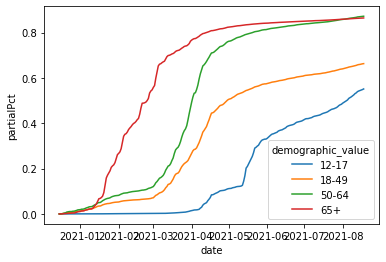

In [16]:
sns.lineplot(
    x="date",
    y="partialPct",
    data=ageGroups,
    hue="demographic_value"
)

In [16]:
output["ages"] = json.loads(ageGroups[["date", "partialPct", 'demographic_value']] \
    .sort_values(by=["demographic_value", "date"]) \
    .reset_index(drop=True) \
    .astype({"date": "string"}) \
    .to_json(orient="records"))

# ageGroups[["date", "partialPct", 'demographic_value']] \
#     .sort_values(by=["demographic_value", "date"]) \
#     .reset_index(drop=True) \
#     .to_csv("../../dist/data/ages.csv")

In [19]:
output.keys()

dict_keys(['ca_vaccines', 'vaccines', 'deaths', 'dailyCases', 'ages'])

In [22]:
import json

with open("../../dist/data/combined.json", "w") as outfile:
    # json.dump(output, outfile)
    outfile.write(json.dumps(output))

In [17]:
np.unique(vaccines_demographics.demographic_category)

array(['Age Group', 'Race/Ethnicity', 'VEM Quartile'], dtype=object)

In [18]:
raceGroups = vaccines_demographics[vaccines_demographics.demographic_category == "Race/Ethnicity"] \
    .reset_index(drop=True)

raceGroups["partialPct"] = raceGroups["cumulative_at_least_one_dose"] / raceGroups["est_population"]

<AxesSubplot:xlabel='date', ylabel='partialPct'>

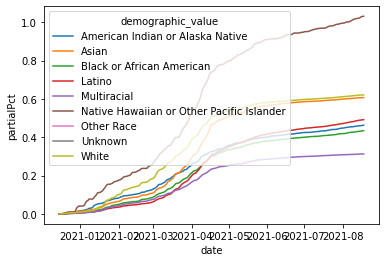

In [26]:
sns.lineplot(
    x="date",
    y="partialPct",
    data=raceGroups,
    hue="demographic_value"
)

In [27]:
raceGroups.groupby("demographic_value").first()

,county,county_type,demographic_category,est_population,est_age_12plus_pop,administered_date,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,cumulative_unvax_total_pop,cumulative_unvax_12plus_pop,suppress_data,date,partialPct
demographic_value,,,,,,,,,,,,,,,,,
American Indian or Alaska Native,Santa Barbara,MIXED,Race/Ethnicity,1924.0,1629.0,2021-08-18,2.0,138.0,1.0,753.0,3.0,891.0,1033.0,738.0,False,2021-08-18,0.463098
Asian,Santa Barbara,MIXED,Race/Ethnicity,21708.0,18370.0,2021-08-18,5.0,1039.0,6.0,12135.0,6.0,13174.0,8534.0,5196.0,False,2021-08-18,0.606873
Black or African American,Santa Barbara,MIXED,Race/Ethnicity,7985.0,6757.0,2021-08-18,5.0,455.0,6.0,3012.0,6.0,3467.0,4518.0,3290.0,False,2021-08-18,0.434189
Latino,Santa Barbara,MIXED,Race/Ethnicity,209673.0,177437.0,2021-08-18,136.0,15347.0,118.0,87755.0,157.0,103102.0,106571.0,74335.0,False,2021-08-18,0.491728
Multiracial,Santa Barbara,MIXED,Race/Ethnicity,10288.0,8706.0,2021-08-18,2.0,212.0,1.0,3007.0,2.0,3219.0,7069.0,5487.0,False,2021-08-18,0.312889
Native Hawaiian or Other Pacific Islander,Santa Barbara,MIXED,Race/Ethnicity,800.0,679.0,2021-08-18,0.0,108.0,1.0,717.0,1.0,825.0,0.0,0.0,False,2021-08-18,1.031250
Other Race,Santa Barbara,MIXED,Race/Ethnicity,NaN,NaN,2021-08-18,62.0,4519.0,17.0,18573.0,70.0,23092.0,NaN,NaN,False,2021-08-18,NaN
Unknown,Santa Barbara,MIXED,Race/Ethnicity,NaN,NaN,2021-08-18,12.0,1616.0,6.0,6408.0,14.0,8024.0,NaN,NaN,False,2021-08-18,NaN
White,Santa Barbara,MIXED,Race/Ethnicity,201120.0,170222.0,2021-08-18,48.0,11917.0,60.0,112977.0,64.0,124894.0,76226.0,45328.0,False,2021-08-18,0.620992


In [8]:

nursing = pd.read_csv("https://data.chhs.ca.gov/dataset/7759311f-1aa8-4ff6-bfbb-ba8f64290ae2/resource/d4d68f74-9176-4969-9f07-1546d81db5a7/download/covid19datanursinghome.csv")
nursing = nursing[nursing["county"] == "Santa Barbara"]
print(nursing.columns)
nursing["date"] = pd.to_datetime(nursing["as_of_date"])

Index(['county', 'facility_id', 'facility_name', 'as_of_date',
       'total_resident_cases', 'new_resident_cases', 'total_resident_deaths',
       'total_health_care_worker_cases', 'new_health_care_worker_cases',
       'total_health_care_workers_deaths', 'note'],
      dtype='object')


<AxesSubplot:xlabel='date', ylabel='total_resident_deaths'>

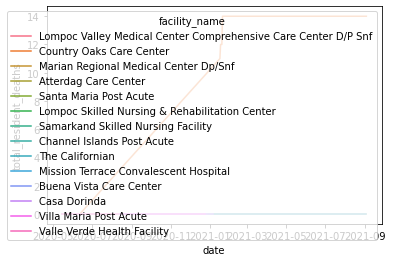

In [9]:
sns.lineplot(
    x="date",
    y="total_resident_deaths",
    data=nursing,
    hue="facility_name"
)